In [1]:
import tensorflow as tf
from tensorflow.python.client import device_lib

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
device_lib.list_local_devices()

Num GPUs Available:  1


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 260055141374024894
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 4176478208
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 9362476157874567188
 physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1660 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5"
 xla_global_id: 416903419]

In [2]:
import tensorflow.keras.utils as np_utils
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.layers import Input, Dense, LayerNormalization, Dropout, GRU
from tensorflow.keras import regularizers, callbacks
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from imutils import paths
import shutil
import csv
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import accuracy_score
from keras.metrics import top_k_categorical_accuracy


In [3]:
train_accs = []
val_accs = []
train_losses = []
val_losses = []

class AccuracyHistoryCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        train_acc = logs.get('accuracy')
        val_acc = logs.get('val_accuracy')
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        train_loss = logs.get('loss')
        val_loss = logs.get('val_loss')
        train_losses.append(train_loss)
        val_losses.append(val_loss)      

def lr_schedule(epoch):
    #if(MAX_FRAMES == 30):
        if epoch < 5:
            return 0.0001
        elif epoch < 12:
            return 0.00005
        else:
            return 0.00001
    #lse:
    #   if epoch < 5:
    #       return 0.00001
    #   elif epoch < 10:
    #       return 0.00001
    #   else:
    #       return 0.000005
    
accuracy_history = AccuracyHistoryCallback()       
top2_acc = lambda y_true, y_pred: top_k_categorical_accuracy(y_true, y_pred, k=2)
# Create a learning rate scheduler callback
def get_callbacks(filepath):
    return [
            keras.callbacks.EarlyStopping(
            monitor="val_accuracy",
            patience = 5,
            restore_best_weights=True
        ),
            keras.callbacks.ReduceLROnPlateau(
            monitor = "val_accuracy",
            factor = 0.5,
            patience = 3
        ),
            keras.callbacks.ModelCheckpoint(
            filepath,
            save_weights_only=True,
            save_best_only=True,
            verbose=1
            ),
            accuracy_history,
            lr_scheduler,
    ]

def GET_MODEL(MAX_FRAMES, MAX_KEYPOINTS):
    model = keras.models.Sequential()
    model.add(Dense(units=1024, input_shape=(MAX_FRAMES, MAX_KEYPOINTS)))
    model.add(LayerNormalization())
    model.add(Dropout(0.6))
    model.add(GRU(units=2048, return_sequences=True))
    model.add(LayerNormalization())
    model.add(Dropout(0.5))
    model.add(GRU(units=1024, return_sequences=True))
    model.add(LayerNormalization())
    model.add(Dropout(0.5))
    model.add(GRU(units=512, return_sequences=True))
    model.add(LayerNormalization())
    model.add(Dropout(0.5))
    model.add(GRU(units=256, return_sequences=True))
    model.add(LayerNormalization())
    model.add(Dropout(0.5))
    model.add(GRU(units=128, return_sequences=False))
    model.add(LayerNormalization())
    model.add(Dropout(0.1))
    model.add(Dense(units=20, activation='softmax'))
    optimizer = optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer,
              loss="categorical_crossentropy",
              metrics=["accuracy",top2_acc])
    return model

In [4]:
all_classes = np.load('NPY_SPLITS/ALL_CLASSES.npy',allow_pickle=True)

Training for frame count: 30
Split: 1 Frames: 30
Epoch 1/16
411/411 [==============================] - ETA: 0s - loss: 2.9188 - accuracy: 0.1125 - <lambda>: 0.2003
Epoch 1: val_loss improved from inf to 2.54795, saving model to SAVED_MODELS\IT5_HOL_30_0.hdf5
411/411 [==============================] - 108s 232ms/step - loss: 2.9188 - accuracy: 0.1125 - <lambda>: 0.2003 - val_loss: 2.5480 - val_accuracy: 0.2321 - val_<lambda>: 0.3564 - lr: 1.0000e-04
Epoch 2/16
411/411 [==============================] - ETA: 0s - loss: 1.2975 - accuracy: 0.5553 - <lambda>: 0.7236
Epoch 2: val_loss improved from 2.54795 to 1.35958, saving model to SAVED_MODELS\IT5_HOL_30_0.hdf5
411/411 [==============================] - 104s 254ms/step - loss: 1.2975 - accuracy: 0.5553 - <lambda>: 0.7236 - val_loss: 1.3596 - val_accuracy: 0.5669 - val_<lambda>: 0.7475 - lr: 1.0000e-04
Epoch 3/16
411/411 [==============================] - ETA: 0s - loss: 0.4795 - accuracy: 0.8443 - <lambda>: 0.9391
Epoch 3: val_loss improv

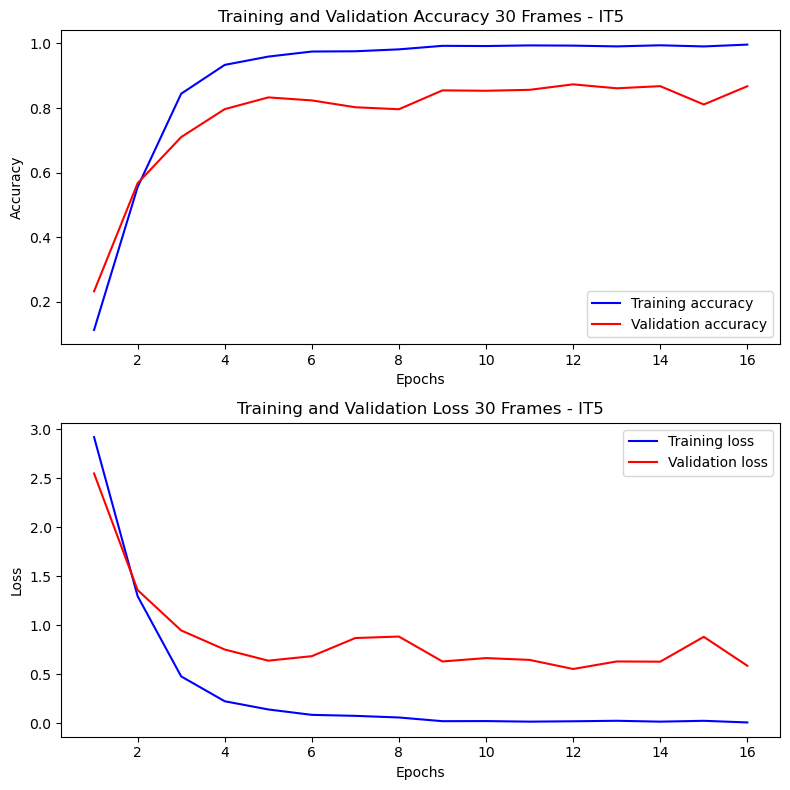

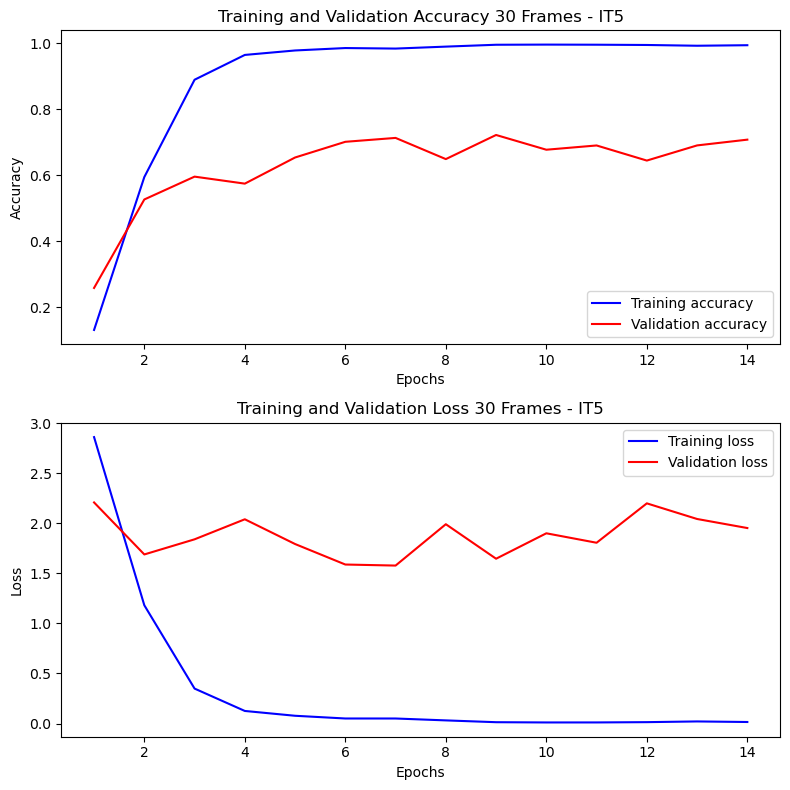

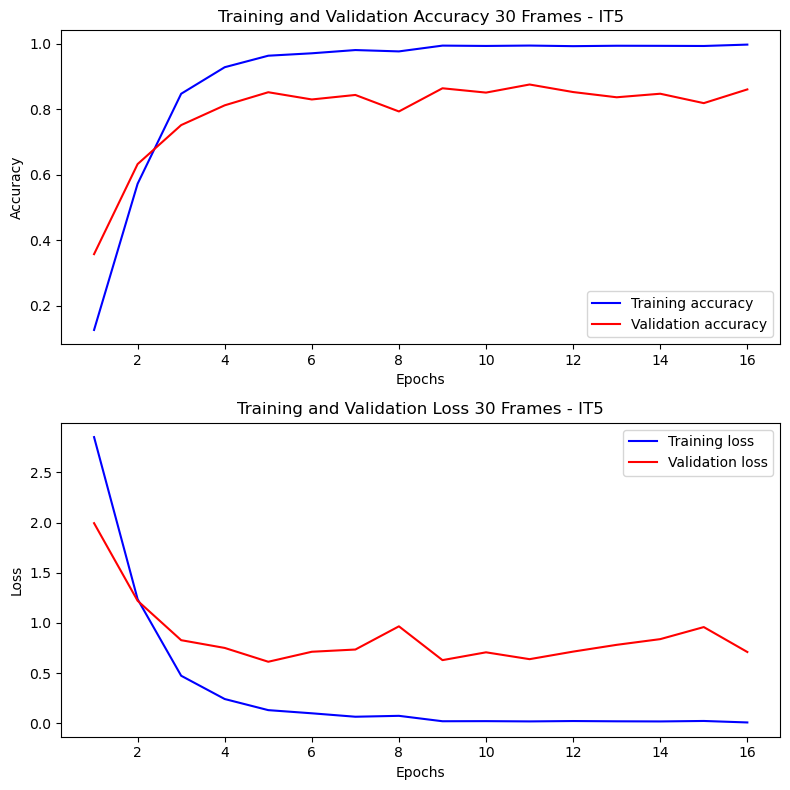

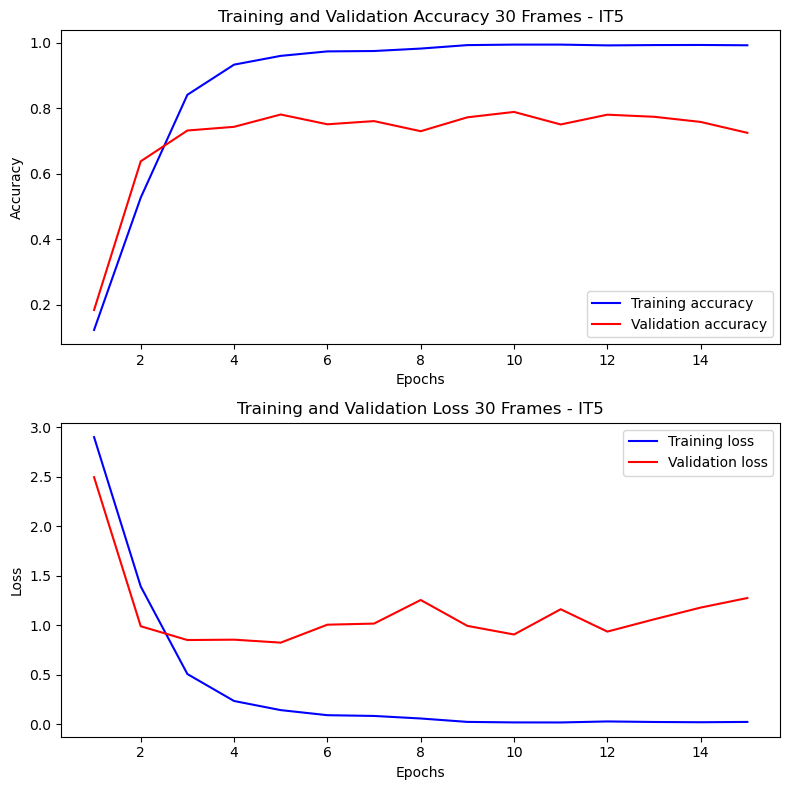

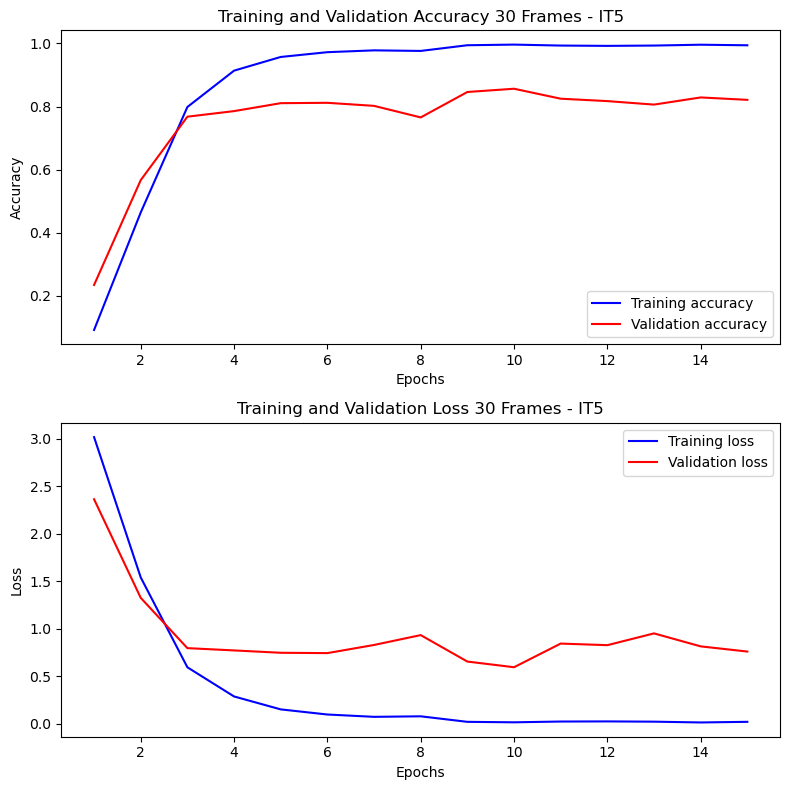

In [5]:
MAX_KEYPOINTS = 202
lr_scheduler = LearningRateScheduler(lr_schedule)

for MAX_FRAMES in [30]:
    print(f"Training for frame count: {MAX_FRAMES}")
    for i in range(0, 5):
        print(f"Split: {i+1} Frames: {MAX_FRAMES}")
        train_filename = f"NPY_SPLITS/train_list_HPF_PCA_HOL_{MAX_FRAMES}_{i}.npy"
        train_label_filename = f"NPY_SPLITS/train_label_HPF_PCA_HOL_{MAX_FRAMES}_{i}.npy"
        test_filename = f"NPY_SPLITS/test_list_HPF_PCA_HOL_{MAX_FRAMES}_{i}.npy"
        test_label_filename = f"NPY_SPLITS/test_label_HPF_PCA_HOL_{MAX_FRAMES}_{i}.npy"
        train_list = np.load(train_filename, allow_pickle=True)
        train_label = np.load(train_label_filename, allow_pickle=True)
        test_list =  np.load(test_filename, allow_pickle=True)
        test_label = np.load(test_label_filename, allow_pickle=True)
        filepath_weights = f"SAVED_MODELS/IT5_HOL_{MAX_FRAMES}_{i}.hdf5"
        y_train_one_hot = np_utils.to_categorical(train_label)
        y_test_one_hot = np_utils.to_categorical(test_label)
        train_accs = []
        val_accs = []
        train_losses = []
        val_losses = []
        model=GET_MODEL(MAX_FRAMES, MAX_KEYPOINTS)
        model.fit(train_list, y_train_one_hot, epochs=16, batch_size=64, 
                  validation_data=(test_list, y_test_one_hot), 
                  callbacks=get_callbacks(filepath_weights))
        del train_filename, train_label_filename, test_filename, \
            test_label_filename, train_list, train_label, test_list, \
                test_label, model
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))
        epochs = range(1, len(train_accs) + 1)
        # Plot the training and validation accuracy
        ax1.plot(epochs, train_accs, 'b', label='Training accuracy')
        ax1.plot(epochs, val_accs, 'r', label='Validation accuracy')
        ax1.set_title(f"Training and Validation Accuracy {MAX_FRAMES} Frames - IT5")
        ax1.set_xlabel('Epochs')
        ax1.set_ylabel('Accuracy')
        ax1.legend()
        
        # Plot the training and validation loss
        ax2.plot(epochs, train_losses, 'b', label='Training loss')
        ax2.plot(epochs, val_losses, 'r', label='Validation loss')
        ax2.set_title(f"Training and Validation Loss {MAX_FRAMES} Frames - IT5")
        ax2.set_xlabel('Epochs')
        ax2.set_ylabel('Loss')
        ax2.legend()
        
        # Adjust spacing between subplots
        plt.tight_layout()
        
        # Save the combined subplot to a file
        plt_filename = f"IT5-combined_plots{MAX_FRAMES}_{i}.png"
        plt.savefig(plt_filename)
        print("*************************DONE******************************")


In [8]:
for MAX_FRAMES in [30]:
    losses = []
    accuracies = []
    k_accuracies = []
    print(f"Eval for frame count: {MAX_FRAMES}")
    for i in range(0, 5):
        test_filename = f"NPY_SPLITS/test_list_HPF_PCA_HOL_{MAX_FRAMES}_{i}.npy"
        test_label_filename = f"NPY_SPLITS/test_label_HPF_PCA_HOL_{MAX_FRAMES}_{i}.npy"
        
        test_list_val =  np.load(test_filename, allow_pickle=True)
        test_label_val = np.load(test_label_filename, allow_pickle=True)
        y_train_one_hot_val = np_utils.to_categorical(test_label_val)
        filepath_weights = f"SAVED_MODELS/IT5_HOL_{MAX_FRAMES}_{i}.hdf5"
        model=GET_MODEL(MAX_FRAMES, MAX_KEYPOINTS)        
        model.load_weights(filepath_weights)
        loss, accuracy, k_accuracy = model.evaluate(test_list_val, y_train_one_hot_val)
        losses.append(loss)
        accuracies.append(accuracy)
        k_accuracies.append(k_accuracy)
    avg_loss = sum(losses) / len(losses)
    avg_accuracy = sum(accuracies) / len(accuracies)
    avg_k_accuracy = sum(k_accuracies) / len(k_accuracies)
    # Print the average results
    print(f"Average Loss with {MAX_FRAMES} frames model:", avg_loss)
    print(f"Average Accuracy with {MAX_FRAMES} frames model:", avg_accuracy*100)
    print(f"Average K-Accuracy with {MAX_FRAMES} frames model:", avg_k_accuracy*100)


Eval for frame count: 30
243/243 [==============================] - 14s 44ms/step - loss: 0.5947 - accuracy: 0.8565 - <lambda>: 0.9356
Average Loss with 30 frames model: 0.8331939578056335
Average Accuracy with 30 frames model: 81.51477575302124
Average K-Accuracy with 30 frames model: 90.76480507850647


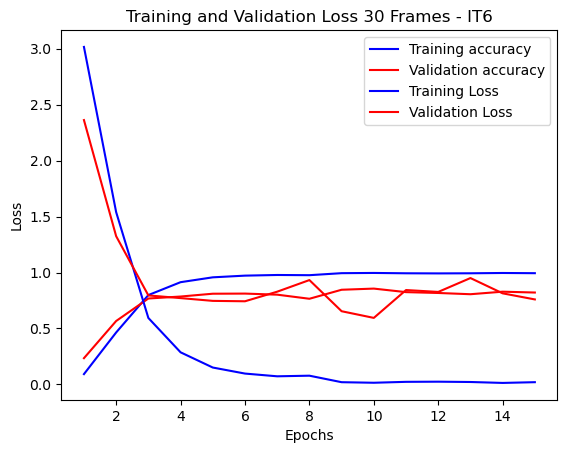

In [7]:
epochs = range(1, len(train_accs) + 1)
plt.plot(epochs, train_accs, 'b', label='Training accuracy')
plt.plot(epochs, val_accs, 'r', label='Validation accuracy')
plt.title(f"Training and Validation Accuracy {MAX_FRAMES} Frames - IT5")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt_filename = f"accuracy_plot{MAX_FRAMES}_{i}.png"
#ve the plot to a file
plt.savefig(plt_filename)     

plt.plot(epochs, train_losses, 'b', label='Training Loss')
plt.plot(epochs, val_losses, 'r', label='Validation Loss')
plt.title(f"Training and Validation Loss {MAX_FRAMES} Frames - IT6")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt_filename2 = f"loss_plot{MAX_FRAMES}_{i}.png"
# Save the plot to a file
plt.savefig(plt_filename2)